In [36]:
import fiftyone as fo
dataset = fo.load_dataset("voc-val")
fo.launch_app(dataset)

Dataset:          voc-val
Media type:       image
Num samples:      4952
Selected samples: 0
Selected labels:  0
Session URL:      http://localhost:5151/

# monitor evaluation for a certain class

In [ ]:
for label in label_list:
    verdict = monitors_dict[label].make_verdicts(features_fp_dict[label])
    print(f"{label} FP: {len(verdict)-np.sum(verdict)}/{len(verdict)} = {(len(verdict)-np.sum(verdict))/len(verdict):.4f}")

# load evaluation results

In [3]:
import torch
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2 import model_zoo
from detectron2.config import get_cfg
import detectron2.data.transforms as T
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import build_model
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data import DatasetMapper, build_detection_test_loader
from detectron2.data import get_detection_dataset_dicts

import numpy as np
import cv2
from PIL import Image
import os
import argparse
from pickle import load

import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone import ViewField as F
torch.manual_seed(0)
np.random.seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

from vos.detection.modeling.regnet import build_regnet_fpn_backbone

In [12]:
backbone = "regnet"
id = "bdd"

In [34]:
import fiftyone as fo
dataset = fo.load_dataset("ID-bdd-OOD-coco")
dataset.count_values("detections.detections.label")

{'teddy bear': 113,
 'cake': 114,
 'tv': 145,
 'bottle': 401,
 'hot dog': 26,
 'donut': 148,
 'vase': 183,
 'elephant': 161,
 'apple': 137,
 'spoon': 125,
 'oven': 90,
 'horse': 70,
 'fork': 102,
 'orange': 177,
 'baseball bat': 15,
 'suitcase': 63,
 'handbag': 9,
 'book': 764,
 'backpack': 14,
 'cat': 164,
 'bowl': 328,
 'laptop': 115,
 'bear': 68,
 'potted plant': 177,
 'dog': 111,
 'carrot': 289,
 'wine glass': 97,
 'pizza': 92,
 'bench': 75,
 'tie': 7,
 'refrigerator': 81,
 'boat': 172,
 'couch': 132,
 'umbrella': 57,
 'surfboard': 22,
 'hair drier': 6,
 'banana': 187,
 'chair': 411,
 'toaster': 8,
 'snowboard': 1,
 'baseball glove': 1,
 'parking meter': 18,
 'giraffe': 199,
 'frisbee': 13,
 'keyboard': 113,
 'broccoli': 294,
 'cell phone': 51,
 'sandwich': 103,
 'sheep': 214,
 'sports ball': 12,
 'bird': 249,
 'kite': 22,
 'dining table': 290,
 'toilet': 152,
 'zebra': 257,
 'cup': 331,
 'sink': 190,
 'remote': 60,
 'airplane': 68,
 'bed': 95,
 'microwave': 40,
 'tennis racket': 1

In [29]:
import fiftyone as fo
# dataset = fo.load_dataset(f"{id}-train")
dataset = fo.load_dataset(f"{id}-train")
dataset.shuffle(seed=42)
subset = dataset.take(1000) 

In [26]:
# # rename the labels
# rename_dict = {"person": "pedestrian", "motor":"motorcycle", "bike":"bicycle"}
# view = dataset.map_labels("detections", rename_dict)
# print(dataset.count_values("detections.detections.label"))
# print(view.count_values("detections.detections.label"))

{'bus': 11672, 'traffic sign': 239686, 'person': 91349, 'bike': 7210, 'car': 713211, 'motor': 3002, 'train': 136, 'truck': 29971, 'rider': 4517, 'traffic light': 186117}
{'traffic sign': 239686, 'bus': 11672, 'pedestrian': 91349, 'car': 713211, 'truck': 29971, 'rider': 4517, 'bicycle': 7210, 'motorcycle': 3002, 'traffic light': 186117, 'train': 136}


In [30]:
VOC_THING_CLASSES = ['person',
                     'bird',
                     'cat',
                     'cow',
                     'dog',
                     'horse',
                     'sheep',
                     'airplane',
                     'bicycle',
                     'boat',
                     'bus',
                     'car',
                     'motorcycle',
                     'train',
                     'bottle',
                     'chair',
                     'dining table',
                     'potted plant',
                     'couch',
                     'tv',
                     ]

BDD_THING_CLASSES = ['pedestrian',
                    'rider',
                    'car',
                    'truck',
                    'bus',
                    'train',
                    'motorcycle',
                    'bicycle',
                    'traffic light',
                    'traffic sign']
label_list = VOC_THING_CLASSES if id == 'voc' else BDD_THING_CLASSES
label_dict = {i:label for i, label in enumerate(label_list)}

In [31]:
cfg = get_cfg()
cfg.merge_from_file(f"vos/detection/configs/BDD-Detection/faster-rcnn/{backbone}.yaml")
cfg.MODEL.WEIGHTS = f"model_final_vos_{backbone}_{id}.pth" 
cfg.MODEL.DEVICE='cuda'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(label_list)
model = build_model(cfg)
model.eval()
checkpointer = DetectionCheckpointer(model)
checkpointer.load(cfg.MODEL.WEIGHTS)

aug = T.ResizeShortestEdge(
            [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
        )
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# %%
def inference(inputs):
    with torch.no_grad():
        images = model.preprocess_image(inputs)  
        features = model.backbone(images.tensor)  
        proposals, _ = model.proposal_generator(images, features, None)  # RPN

        features_ = [features[f] for f in model.roi_heads.box_in_features]
        box_features = model.roi_heads.box_pooler(features_, [x.proposal_boxes for x in proposals])
        box_features = model.roi_heads.box_head(box_features)  # features of all 1k candidates
        predictions = model.roi_heads.box_predictor(box_features)
        pred_instances, pred_inds = model.roi_heads.box_predictor.inference(predictions, proposals)
        pred_instances = model.roi_heads.forward_with_given_boxes(features, pred_instances)

        # output boxes, masks, scores, etc
        pred_instances = model._postprocess(pred_instances, inputs, images.image_sizes)  # scale box to orig size
        # features of the proposed boxes
        feats = box_features[pred_inds]
    return pred_instances, feats


with fo.ProgressBar() as pb:
    for sample in pb(subset):
        image = cv2.imread(sample.filepath)
        height, width = image.shape[:2]
        image = aug.get_transform(image).apply_image(image)
        image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1)).to(device)
        inputs = [{"image": image, "height": height, "width": width}]
        preds, feats = inference(inputs)
        feats = feats.cpu().detach().numpy()
        boxes = preds[0]["instances"].get("pred_boxes").tensor.cpu().detach().numpy()
        scores = preds[0]["instances"].get("scores").cpu().detach().numpy()
        classes = preds[0]["instances"].pred_classes.cpu().detach().numpy()
        
        detections = []
        oods = []             
        for label, score, box, feat in zip(classes, scores, boxes, feats):
            label = label_dict[label]
            x1, y1, x2, y2 = box
            rel_box = [x1/width, y1/height, (x2 - x1) / width, (y2 - y1) / height]
            detections.append(
                fo.Detection(
                    label=label,
                    bounding_box=rel_box,
                    confidence=score
                ),
            )
        sample["prediction"] = fo.Detections(detections=detections)
        sample.save()

[05/12 17:36:21 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from model_final_vos_regnet_bdd.pth ...


The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std
  roi_heads.logistic_regression.{bias, weight}
  roi_heads.noise.noise
  roi_heads.weight_energy.{bias, weight}


   0% |---------------|    2/1000 [1.2s elapsed, 9.6m remaining, 1.7 samples/s]  

/home/hugo/miniconda3/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343962757/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


 100% |███████████████| 1000/1000 [1.7m elapsed, 0s remaining, 10.4 samples/s]      


In [32]:
results = subset.evaluate_detections(
        "prediction",
        gt_field="detections",
        eval_key="eval",
        compute_mAP=True,
        )

Evaluating detections...
 100% |███████████████| 1000/1000 [38.6s elapsed, 0s remaining, 26.4 samples/s]      
Performing IoU sweep...
 100% |███████████████| 1000/1000 [26.2s elapsed, 0s remaining, 39.0 samples/s]      


In [33]:
results.print_report()

               precision    recall  f1-score   support

      bicycle       0.80      0.62      0.70       102
          bus       0.70      0.70      0.70       150
          car       0.83      0.79      0.81      9871
   motorcycle       0.76      0.74      0.75        35
   pedestrian       0.76      0.68      0.72      1114
        rider       0.77      0.58      0.66        69
traffic light       0.69      0.68      0.69      2444
 traffic sign       0.71      0.75      0.73      3316
        train       0.00      0.00      0.00         3
        truck       0.75      0.67      0.71       436

    micro avg       0.78      0.76      0.77     17540
    macro avg       0.68      0.62      0.65     17540
 weighted avg       0.78      0.76      0.77     17540



# merge monitors to a dict

In [1]:
from pickle import load
monitors_dict = {}
label_dict = {
            0: 'person',
            1: 'rider',
            2: 'car',
            3: 'truck',
            4: 'bus',
            5: 'train',
            6: 'motor',
            7: 'bike',
            8: 'traffic light',
            9: 'traffic sign',
            10: 'OOD'
        }
label_list = list(label_dict.values())
tau = 0.05
for class_name in label_list:
    if class_name == "train" or class_name == "OOD":
        continue
    monitor_path = f"monitors/bdd/regnet/{class_name}/monitor_for_clustering_parameter" + "_tau_" + str(tau) + ".pkl"
    with open(monitor_path, 'rb') as f:
        monitor = load(f)
    monitors_dict[class_name] = monitor
print(monitors_dict)
# # save monitors_dict
# import pickle
# with open("monitors_dict.pkl", 'wb') as f:
#     pickle.dump(monitors_dict, f)

{'person': <runtime_monitors.Monitor.Monitor object at 0x7f04d4509a30>, 'rider': <runtime_monitors.Monitor.Monitor object at 0x7f04d4509c70>, 'car': <runtime_monitors.Monitor.Monitor object at 0x7f04d45c4670>, 'truck': <runtime_monitors.Monitor.Monitor object at 0x7f04c406e0d0>, 'bus': <runtime_monitors.Monitor.Monitor object at 0x7f04c406e220>, 'motor': <runtime_monitors.Monitor.Monitor object at 0x7f04c406e640>, 'bike': <runtime_monitors.Monitor.Monitor object at 0x7f04c406e910>, 'traffic light': <runtime_monitors.Monitor.Monitor object at 0x7f04c406ee20>, 'traffic sign': <runtime_monitors.Monitor.Monitor object at 0x7f04c40705b0>}


In [2]:
monitor_person = monitors_dict["person"]

In [13]:
monitor_person.good_ref[0].ivals

[[0.0, 0.5848375],
 [0.0, 0.5834033],
 [0.6861365, 3.532072],
 [0.0, 2.0977945],
 [0.0, 0.0],
 [1.1966999, 4.034026],
 [0.0, 1.7002876],
 [0.0, 1.306643],
 [0.0, 0.19737662],
 [0.0, 3.979893],
 [0.0, 1.118169],
 [0.0, 0.64924026],
 [0.0, 1.2099701],
 [0.0, 0.7803887],
 [0.0, 1.145529],
 [0.0, 0.5261299],
 [0.0, 1.4346224],
 [0.0, 0.6294101],
 [0.0, 1.7197112],
 [0.0, 1.992035],
 [0.0, 0.43605697],
 [0.0, 1.5746248],
 [0.0, 0.26059672],
 [0.0, 0.8940954],
 [0.32682613, 2.7179537],
 [0.0, 0.11865173],
 [0.0, 0.98223877],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.7357377],
 [0.0, 1.2567421],
 [0.0, 3.1575541],
 [0.0, 1.109943],
 [0.0, 0.22470652],
 [0.0, 0.25853014],
 [0.0, 1.029324],
 [0.0, 0.0],
 [0.0, 2.8686771],
 [0.0, 1.0002831],
 [0.0, 0.78923804],
 [0.0, 0.049035326],
 [0.0, 1.1453979],
 [0.0, 0.8935785],
 [0.0, 1.7255433],
 [0.0, 1.1808965],
 [0.0, 0.38427144],
 [0.0, 2.2868645],
 [0.0, 0.66995245],
 [0.0, 2.3704424],
 [0.0, 0.0467209],
 [0.0, 0.8770404],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0,

# inference on voc

In [1]:
import torch, torchvision
from torchviz import make_dot
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2 import model_zoo
from detectron2.config import get_cfg
import detectron2.data.transforms as T
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import build_model
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data.detection_utils import read_image
from detectron2.data import MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.config import get_cfg
import numpy as np
import cv2
from PIL import Image
import os
import sys
import random
import gradio as gr
import pandas as pd
import matplotlib.pyplot as plt
import io

import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone import ViewField as F
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [2]:
fo.list_datasets()

['ID-bdd-OOD-coco',
 'ID-voc-OOD-coco',
 'OOD-open',
 'bdd-train',
 'bdd-val',
 'voc-train',
 'voc-val']

In [3]:
cfg = get_cfg()
cfg.merge_from_file("vos/detection/configs/BDD-Detection/faster-rcnn/vanilla.yaml")
# cfg.MODEL.WEIGHTS = "model_final_vanilla_resnet_bdd.pth" 
cfg.MODEL.WEIGHTS = "model_final_vos_resnet_voc.pth" 
cfg.MODEL.DEVICE='cuda'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 20
predictor = DefaultPredictor(cfg)

[05/03 00:01:20 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from model_final_vos_resnet_voc.pth ...


The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std
  roi_heads.logistic_regression.{bias, weight}
  roi_heads.noise.noise
  roi_heads.weight_energy.{bias, weight}


In [8]:
fo.list_datasets()

['ID-bdd-OOD-coco',
 'ID-voc-OOD-coco',
 'OOD-open',
 'bdd-train',
 'bdd-val',
 'voc-train',
 'voc-val']

In [7]:
import numpy as np
import glob
import os
for file in glob.glob("Bdd_feats_20k/*.npy"):
    print(os.path.basename(file))
    print(np.load(file).shape)

feats_motor.npy
(361, 1024)
feats_bike.npy
(1019, 1024)
feats_bus.npy
(1709, 1024)
feats_rider.npy
(597, 1024)
feats_car.npy
(144061, 1024)
feats_truck.npy
(4157, 1024)
feats_pedestrian.npy
(14623, 1024)
feats_traffic light.npy
(30976, 1024)
feats_train.npy
(0, 1024)
feats_traffic sign.npy
(43504, 1024)


In [9]:
dataset = fo.load_dataset("voc-val")

In [10]:
dataset

Name:        voc-val
Media type:  image
Num samples: 4952
Persistent:  True
Tags:        []
Sample fields:
    id:         fiftyone.core.fields.ObjectIdField
    filepath:   fiftyone.core.fields.StringField
    tags:       fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:   fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    detections: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)

In [11]:
fo.launch_app(dataset)

Dataset:          voc-val
Media type:       image
Num samples:      4952
Selected samples: 0
Selected labels:  0
Session URL:      http://localhost:5151/

In [4]:
VOC_THING_CLASSES = ['person',
                     'bird',
                     'cat',
                     'cow',
                     'dog',
                     'horse',
                     'sheep',
                     'airplane',
                     'bicycle',
                     'boat',
                     'bus',
                     'car',
                     'motorcycle',
                     'train',
                     'bottle',
                     'chair',
                     'dining table',
                     'potted plant',
                     'couch',
                     'tv',
                     ]
MetadataCatalog.get("voc_dataset").set(thing_classes=VOC_THING_CLASSES)

namespace(name='voc_dataset',
          thing_classes=['person',
                         'bird',
                         'cat',
                         'cow',
                         'dog',
                         'horse',
                         'sheep',
                         'airplane',
                         'bicycle',
                         'boat',
                         'bus',
                         'car',
                         'motorcycle',
                         'train',
                         'bottle',
                         'chair',
                         'dining table',
                         'potted plant',
                         'couch',
                         'tv'])

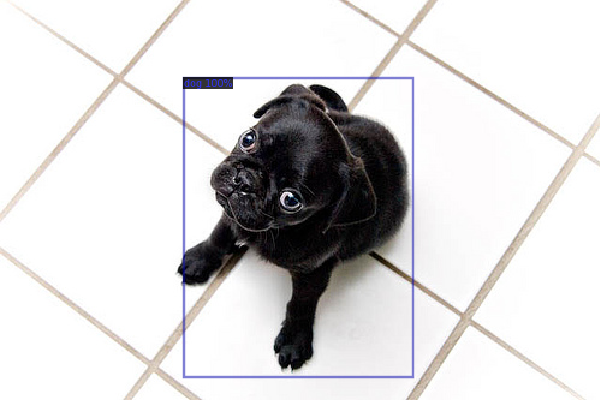

In [7]:
# take a random sample from the dataset
sample = dataset.take(1)
im = cv2.imread(sample.first().filepath)
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get("voc_dataset"), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
img = v.get_image()
Image.fromarray(img)

# load voc train dataset

In [10]:
import fiftyone as fo
# The directory containing the source images
data_path = "~/fiftyone/VOC_0712_converted/JPEGImages"

# The path to the BDD100k labels JSON file
labels_path = "~/fiftyone/VOC_0712_converted/voc0712_train_all.json"

# Import the dataset
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=data_path,
    labels_path=labels_path,
    name = "voc-train",
)
dataset.persistent = True

 100% |█████████████| 16551/16551 [32.7s elapsed, 0s remaining, 415.1 samples/s]      


In [ ]:
dataset = fo.load_dataset("voc-train")
fo.launch_app(dataset)

# voc classes

In [50]:
label_dict = {
    0: 'person',
    1: 'rider',
    2: 'car',
    3: 'truck',
    4: 'bus',
    5: 'train',
    6: 'motor',
    7: 'bike',
    8: 'traffic light',
    9: 'traffic sign'
}
label_list = list(label_dict.values())

In [ ]:
fo.list_datasets()

In [51]:
{i:label for i, label in enumerate(label_list)}

{0: 'person',
 1: 'rider',
 2: 'car',
 3: 'truck',
 4: 'bus',
 5: 'train',
 6: 'motor',
 7: 'bike',
 8: 'traffic light',
 9: 'traffic sign'}

In [14]:
VOC_THING_CLASSES = ['person',
                     'bird',
                     'cat',
                     'cow',
                     'dog',
                     'horse',
                     'sheep',
                     'airplane',
                     'bicycle',
                     'boat',
                     'bus',
                     'car',
                     'motorcycle',
                     'train',
                     'bottle',
                     'chair',
                     'dining table',
                     'potted plant',
                     'couch',
                     'tv',
                     ]
VOC_ID_THING_CLASSES = [
'person', 'dog', 'horse', 'sheep', 'motorcycle', 'train', 'dining table', 'potted plant', 'couch', 'tv'
]
VOC_OOD_THING_CLASSES = [
'bird', 'cat', 'cow' , 'airplane', 'bicycle', 'boat', 'bus', 'car', 'bottle', 'chair'
]

In [15]:
len(VOC_ID_THING_CLASSES),len(VOC_OOD_THING_CLASSES)

(10, 10)

In [16]:
len(VOC_THING_CLASSES)

20

# load bdd val dataset

In [8]:
# dataset_bdd_val = fo.load_dataset("load_bdd")
# # The directory containing the source images
data_path = "~/fiftyone/bdd100k/images/100k/val"

# The path to the BDD100k labels JSON file
labels_path = "~/fiftyone/bdd100k/val_bdd_converted.json"

# Import the dataset
dataset_bdd_val = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=data_path,
    labels_path=labels_path,
    name = "load_bdd",
)

 100% |█████████████| 10000/10000 [5.9m elapsed, 0s remaining, 32.1 samples/s]      


In [9]:
dataset_bdd_val.persistent = True
dataset_bdd_val.name = "bdd-val"

In [ ]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset("voc-2012", split="train")

session = fo.launch_app(dataset)

# load custom dataset

In [17]:
import fiftyone as fo
# The directory containing the source images
data_path = "/home/hugo/fiftyone/coco-2017/validation/data"

# The path to the BDD100k labels JSON file
labels_path = "/home/hugo/fiftyone/coco-2017/instances_val2017_ood_rm_overlap.json"

# Import the dataset
dataset_bdd_val = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=data_path,
    labels_path=labels_path,
    name = "ID-voc-OOD-coco",
)
dataset_bdd_val.persistent = True

 100% |█████████████████| 930/930 [4.8s elapsed, 0s remaining, 185.5 samples/s]      



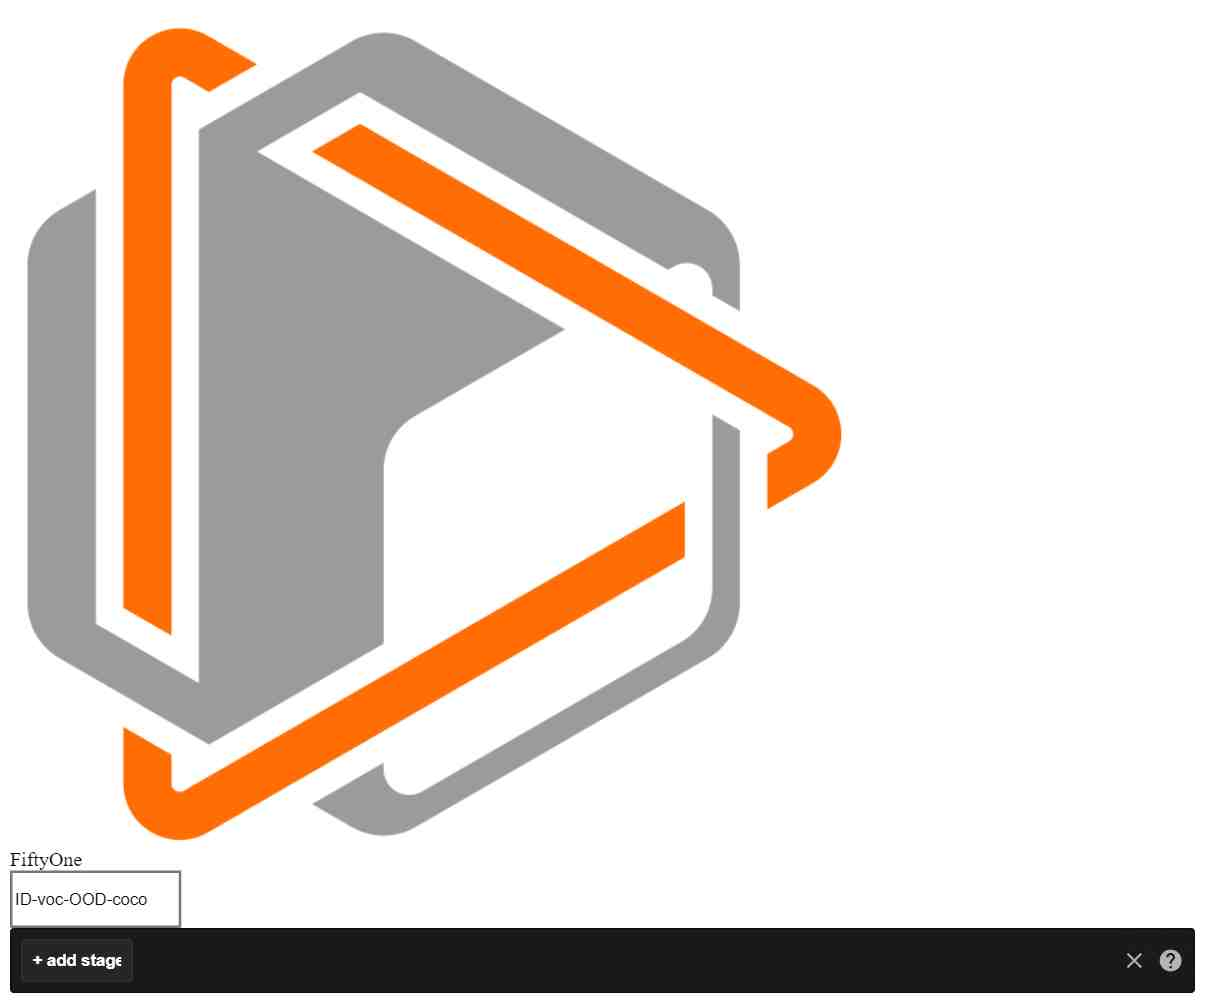

Dataset:          ID-voc-OOD-coco
Media type:       image
Num samples:      930
Selected samples: 0
Selected labels:  0
Session URL:      http://localhost:5151/

In [18]:
fo.launch_app(dataset_bdd_val)

# load bdd train dataset

Split 'train' already prepared
Loading 'bdd100k' split 'train'
 100% |█████████████| 70000/70000 [17.2m elapsed, 0s remaining, 29.5 samples/s]      
Dataset 'bdd100k-train' created



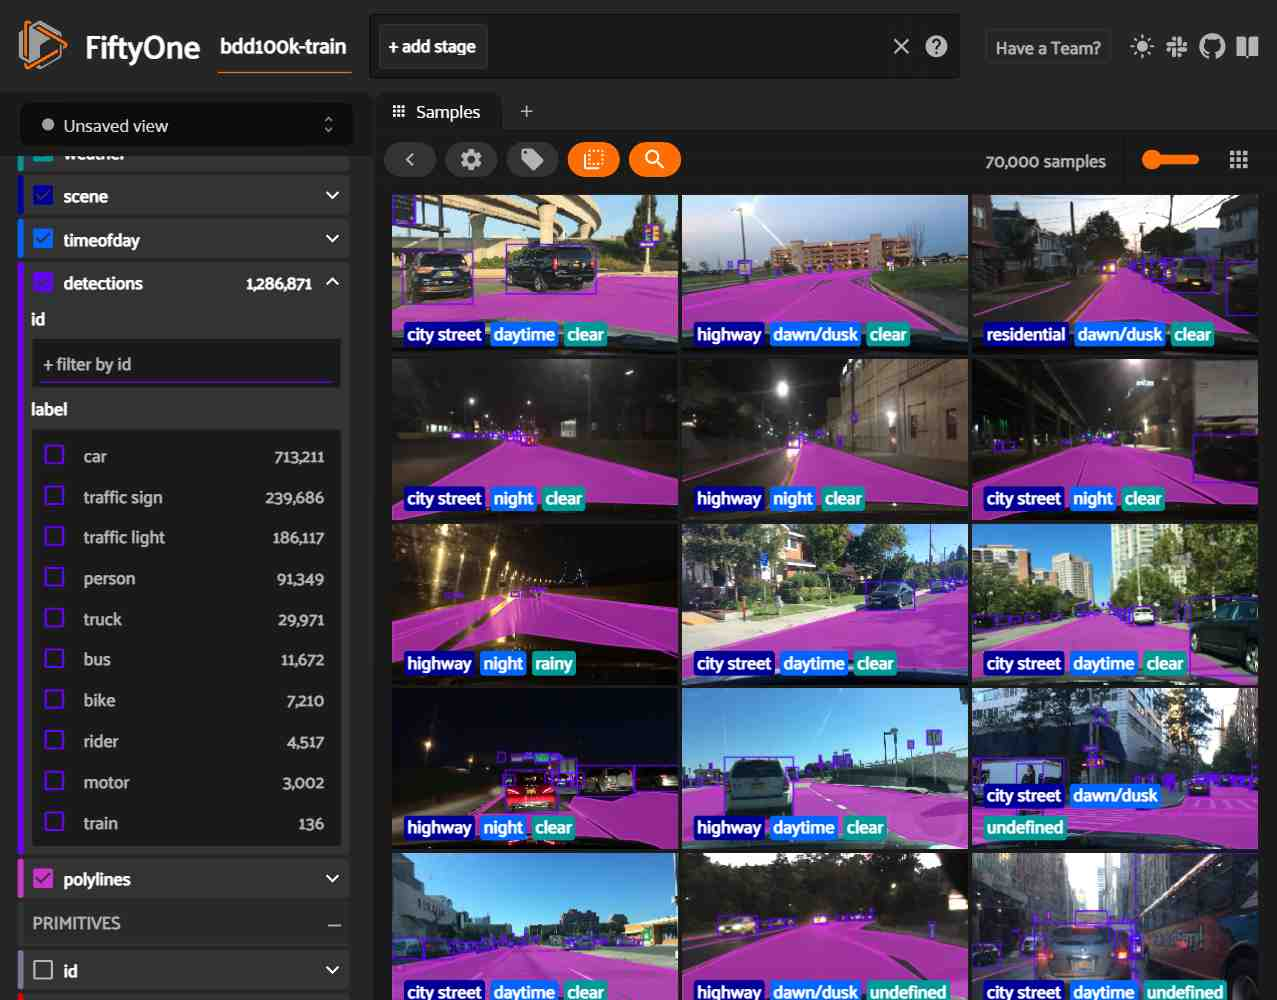

In [10]:
import fiftyone as fo
import fiftyone.zoo as foz

# The path to the source files that you manually downloaded
source_dir = "~/fiftyone/bdd100k"

dataset = foz.load_zoo_dataset(
    "bdd100k",
    split="train",
    source_dir=source_dir,
)

session = fo.launch_app(dataset)

# filtering out small objects

In [ ]:
fo.launch_app(subset)
label_selected = ["car", "person", "traffic light", "traffic sign", "truck"]
ds_selected = dataset.filter_labels("detections", F("label").is_in(label_selected))
ds_selected
# compute pixel area for each object and add it to a list by label
pixel_area_dict = {"car": [], "person": [], "traffic light": [], "traffic sign": [], "truck": []}
with fo.ProgressBar() as pb:
    for sample in pb(ds_selected):
        width, height = sample.metadata['width'], sample.metadata['height']
        if sample.detections:
            for detection in sample.detections.detections:
                rel_x, rel_y, rel_w, rel_h = detection.bounding_box
                pixel_area = (rel_w * width) * (rel_h * height)
                label = detection.label
                # Add pixel area attribute to the detection
                pixel_area_dict[label].append(pixel_area)

# plot a box plot for pixel area by label
import matplotlib.pyplot as plt
fig, axs = plt.subplots(ncols=len(pixel_area_dict), figsize=(40, 8))

for ax, (label, pixel_area) in zip(axs, pixel_area_dict.items()):
    ax.boxplot(pixel_area)
    ax.set_title(label)

plt.show()
# remove outliers in box plot
import numpy as np
pixel_area_dict_filtered = {"car": [], "person": [], "traffic light": [], "traffic sign": [], "truck": []}
for label, pixel_area in pixel_area_dict.items():
    q1, q3 = np.percentile(pixel_area, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    print(label, "lb:", lower_bound, "ub:", upper_bound)
    for area in pixel_area:
        if area > lower_bound and area < upper_bound:
            pixel_area_dict_filtered[label].append(area)
fig, axs = plt.subplots(ncols=len(pixel_area_dict_filtered), figsize=(40, 8))

for ax, (label, pixel_area) in zip(axs, pixel_area_dict_filtered.items()):
    ax.boxplot(pixel_area)
    ax.set_title(label)

plt.show()
for label, pixel_area in pixel_area_dict.items():
    q1, q3 = np.percentile(pixel_area, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    print(label, "q1:", q1, "q3:", q3)
    print(label, "lb:", lower_bound, "ub:", upper_bound)
    for area in pixel_area:
        if area > lower_bound and area < upper_bound:
            pixel_area_dict_filtered[label].append(area)
subset = ds_selected.take(20000)
threshold_dict = {"car": 450, "person": 500, "traffic light": 150, "traffic sign": 250, "truck": 1500}
bbox_area = (
    F("$metadata.width") * F("bounding_box")[2] *
    F("$metadata.height") * F("bounding_box")[3]> threshold_dict[F("label")]
)

# threshold = ()
# no_small_boxes = bbox_area > threshold

# Create a view that doesn't contain only any GT and predicted boxes
nosmall_boxes_eval_view = (
    ds_selected
    .filter_labels("detections", bbox_area, only_matches=True)
    .filter_labels("prediction", bbox_area, only_matches=True)
)

In [ ]:
features_idx_dict = {}
for label in class_names:
    features_idx_dict[label] = []
with fo.ProgressBar() as pb:
    for sample in pb(tp_prediction_view):
        # size = [sample.metadata["width"], sample.metadata["height"]]
        for detection in sample.prediction.detections:
            label_pred = detection.label
            feature_idx = detection.feature_idx
            # rel_x, rel_y, rel_w, rel_h = detection.bounding_box
            # pixel_area = (rel_w * width) * (rel_h * height)
            # if label_pred in class_names:
                # if pixel_area >= threshold_dict[label_pred]:
                    # features_dict[label_pred].append(detection.feature)
            features_idx_dict[label_pred].append(feature_idx)